In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
import keras.layers as ll
from keras.models import Sequential
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

from mpl_toolkits.mplot3d import Axes3D
%pylab inline

/home/hellmetler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


### Preproc

In [2]:
data_path = '../data/raw/'
interim_path = '../data/interim/'
result_path = '../submits/'
figures_path = '../reports/figures/'

In [3]:
train = pd.read_csv(data_path+'train.csv', index_col=0, 
                    dtype={'meter_id':str,'Timestamp':str, 'Values':np.float32})
test = pd.read_csv(data_path+'submission_format.csv',dtype={'obs_id':np.int32,'meter_id':str,
                                                            'Timestamp':str, 'is_abnormal':bool})
metadata = pd.read_csv(data_path+'metadata.csv',dtype={'site_id':str,'meter_id':str,'meter_description':str,
                                                            'units':str, 'surface':np.float32,'activity':str})
holidays =  pd.read_csv(data_path+'holidays.csv', index_col=0, 
                    dtype={'Date':str,'Holiday':str, 'site_id':str})
weather =  pd.read_csv(data_path+'weather.csv', index_col=0, 
                    dtype={'Timestamp':str,'Temperature':np.float32,'Distance':np.float32 ,'site_id':str})

train.Timestamp = pd.to_datetime(train.Timestamp)
test.Timestamp = pd.to_datetime(test.Timestamp)
holidays.Date = pd.to_datetime(holidays.Date)
weather.Timestamp = pd.to_datetime(weather.Timestamp)

/home/hellmetler/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
train = train.join(metadata.set_index('meter_id',drop = True), on = 'meter_id')

In [5]:
meter = '234_203'
site = train[train['meter_id']==meter].site_id.unique()[0]

holidays = holidays[holidays['site_id']=='334_61']

train = train[train['site_id']==site]
weather = weather[weather['site_id']==site]
weather = weather.groupby('Timestamp',as_index= False).mean()

In [6]:
tmp = train[['meter_id','meter_description','units','surface']]

In [7]:
train_left = train[train['meter_id']==site]
for met_id in train['meter_id'].unique():
    if met_id != site:
        tmp = train.loc[train['meter_id']==met_id,['Timestamp','Values']].set_index('Timestamp',drop = True)
        train_left = train_left.join(tmp, on = 'Timestamp',rsuffix = '_'+met_id )
train = train_left
del train_left

In [8]:
def basic_feature_engineering(df):
    
    night_hours = {20:0,21:1,22:2,23:3,0:4,1:5,2:6,3:7,4:8,5:9,6:10}
    day_hours = dict([(h,i) for i,h in enumerate(range(7,20))])
    
    df['year'] = pd.DatetimeIndex(df['Timestamp']).year
    df['month'] = pd.DatetimeIndex(df['Timestamp']).month
    
    df['month_sin'] = np.sin(df['month']*2*pi/12)
    df['month_cos'] = np.cos(df['month']*2*pi/12)
    
    
    df['day'] = pd.DatetimeIndex(df['Timestamp']).day
        
    df['day_sin'] = np.sin(df['day']*2*pi/30)
    df['day_cos'] = np.cos(df['day']*2*pi/30)
    
    df['day_of_week'] = pd.DatetimeIndex(df['Timestamp']).weekday_name
    df['woking_day'] = (df['day_of_week']!= 'Saturday' )&(df['day_of_week']!= 'Sunday' )
    df['weekofyear'] = pd.DatetimeIndex(df['Timestamp']).weekofyear
    df['weekofyear_sin'] = np.sin(df['weekofyear']*2*pi/52)
    df['weekofyear_cos'] = np.cos(df['weekofyear']*2*pi/52)
    
    df['dayofyear'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
    df['dayofyear_sin'] = np.sin(df['dayofyear']*2*pi/365)
    df['dayofyear_cos'] = np.cos(df['dayofyear']*2*pi/365)
    
    
    df['hour'] = pd.DatetimeIndex(df['Timestamp']).hour
    
    df['hour_sin'] = np.sin(df['hour']*2*pi/24)
    df['hour_cos'] = np.cos(df['hour']*2*pi/24)
    
    df.loc[(((df['hour']>=20 )&(df['hour']<= 23 ))|((df['hour']>=0 )&(df['hour']< 7 ))),'night']= True
    df['night'].fillna(False,inplace = True)
    
    df.loc[df['night']==True,'reset_hour']= df.loc[df['night']==True,'hour'].apply(lambda x: night_hours[x] )
    df.loc[df['night']==False,'reset_hour']= df.loc[df['night']==False,'hour'].apply(lambda x: day_hours[x] )
    
    df.loc[(((df['hour']>=22 )&(df['hour']<= 23 ))|((df['hour']>=0 )&(df['hour']< 7 ))),'time_of_day']= 0
    df.loc[(((df['hour']>=7 )&(df['hour']< 10 ))|((df['hour']>=18 )&(df['hour']< 22 ))),'time_of_day']= 1
    df.loc[(((df['hour']>=10 )&(df['hour']< 18 ))),'time_of_day']= 2
    
    df['minute'] = pd.DatetimeIndex(df['Timestamp']).minute
    return df

In [9]:
train = basic_feature_engineering(train)

In [10]:
train.dropna(subset = ['Values'], inplace = True)

In [11]:
weather['year'] = pd.DatetimeIndex(weather['Timestamp']).year
weather['month'] = pd.DatetimeIndex(weather['Timestamp']).month
weather['day'] = pd.DatetimeIndex(weather['Timestamp']).day
weather['hour'] = pd.DatetimeIndex(weather['Timestamp']).hour
weather = weather.groupby(['year','month','day','hour'], as_index = False).mean()

In [12]:
train = pd.merge(train,weather[['year','month','day','hour','Temperature']], how='left', 
                 on = ['year','month','day','hour'])

In [13]:
train = train.join(train[['year','month','day','Temperature']].groupby(['year','month','day']).mean(),
           on = ['year','month','day'],rsuffix = '_mean_date')

In [14]:
train['Temperature_sq']=train['Temperature']**2

In [15]:
train['night'] = train['night'].astype(int)
train = train.join(train[['year','month','day','night','Temperature']].groupby(['year','month','day','night']).mean(),
           on = ['year','month','day','night'],rsuffix = '_mean_time_of_day')

In [16]:
holidays['year'] = pd.DatetimeIndex(holidays['Date']).year
holidays['month'] = pd.DatetimeIndex(holidays['Date']).month
holidays['day'] = pd.DatetimeIndex(holidays['Date']).day
holidays['is_holiday'] = True
holidays.drop_duplicates(subset = ['Date'], inplace = True)

In [17]:
train = train.join(holidays[['year','month','day','is_holiday']].set_index(['year','month','day']),
                   on = ['year','month','day'])

In [18]:
#manually labeled new year holidays

train.loc[(train['Timestamp']>'2013-12-21')&(train['Timestamp']<'2014-01-08'),'is_holiday'] = True
train.loc[(train['Timestamp']>'2014-12-21')&(train['Timestamp']<'2015-01-08'),'is_holiday'] = True
train.loc[(train['Timestamp']>'2015-12-21')&(train['Timestamp']<'2016-01-08'),'is_holiday'] = True
train.loc[(train['Timestamp']>'2016-12-21')&(train['Timestamp']<'2017-02-08'),'is_holiday'] = True
train.loc[(train['Timestamp']>'2017-12-21')&(train['Timestamp']<'2018-01-08'),'is_holiday'] = True


#train.loc[(train['Timestamp']=='2015-10-26'),'is_holiday'] = True

In [19]:
all_values = train[['meter_id','Timestamp','Values']]

In [20]:
train = train[train['is_holiday']!=True]
train.is_holiday.fillna(False, inplace = True)
train['is_holiday'] = train['is_holiday'].astype(int)

In [21]:
train['is_abnormal'] = False

In [22]:
#predicting only stationare part of train set
train['part_1'] = train['Timestamp']<'2014-12-05'
train['part_2'] = (train['Timestamp']>'2014-12-05')&(train['Timestamp']<'2015-06-21')
train['part_3'] = (train['Timestamp']>'2015-06-21')&(train['Timestamp']<'2015-08-03')
train['part_4'] = train['Timestamp']>'2015-08-03'

#train = train.loc[(train['Timestamp'] <'2017-01-20')|(train['Timestamp'] >'2017-02-04'),:]

train['part_1'].fillna(False, inplace = True)
train['part_2'].fillna(False, inplace = True)
train['part_3'].fillna(False, inplace = True)
train['part_4'].fillna(False, inplace = True)

train= train[train['part_4']==True]

In [23]:
train['high_temp'] =train ['Temperature_mean_date']>15

train.loc[(train.Timestamp>'2015-08-09')&(train.Timestamp<'2015-08-15'),'is_holiday']= True
train.loc[((train['woking_day']==True)&(train['high_temp']==True)&(train['is_holiday']==False)),'model_num'] = 1
train.loc[((train['woking_day']==True)&(train['high_temp']==False)&(train['is_holiday']==False)),'model_num'] = 2
train.loc[((train['woking_day']==False)&(train['high_temp']==False)&(train['is_holiday']==False)),'model_num'] = 3
train.loc[((train['woking_day']==False)&(train['high_temp']==True)&(train['is_holiday']==False)),'model_num'] = 4
train ['model_num'].fillna(0,inplace = True)


### modeling

In [24]:
scaler = StandardScaler()

In [25]:
cols = ['dayofyear','weekofyear','woking_day', 'weekofyear_sin', 'weekofyear_cos','dayofyear_sin','dayofyear_cos', 'hour_sin', 
        'hour_cos', 'night','Temperature', 'Temperature_sq','Temperature_mean_date','Temperature_mean_time_of_day','Values']


x_cols = ['Temperature_mean_time_of_day','Temperature_mean_date','dayofyear_sin','dayofyear_cos','Temperature',
        'hour_sin', 'hour_cos']


scale_cols = ['Temperature_mean_time_of_day','Temperature_mean_date','Temperature']

#### working day any temp

In [26]:
train_1 = train.loc[(train['model_num']==1)|(train['model_num']==2)].copy()

In [27]:
##knn
model = KNeighborsRegressor(n_neighbors=1000,p=1, n_jobs=-1)
scaler = StandardScaler()

x_train = train_1.dropna(subset = x_cols)[x_cols]
x_train.loc[:,scale_cols] = scaler.fit_transform(x_train[scale_cols].values)
y_train = train_1.dropna(subset = x_cols)['Values']

model.fit(x_train,y_train)
y_pred = model.predict(x_train)
(mean_absolute_error(y_train,y_pred))

7715.1821

In [28]:
train_1.loc[x_train.index,'Values_pred_2'] = y_pred
train_1['error_2'] = (train_1['Values']-train_1['Values_pred_2'])
train_1['metric_2'] = np.abs(train_1['error_2']-train_1['error_2'].mean())/(train_1['error_2'].std())

threshold = 3.5
train_1['is_abnormal_2']=train_1['metric_2']>threshold
train_1['is_abnormal_2'].fillna(False,inplace = True)

In [29]:

cols_nn = ['Values','Temperature','hour','year','month','day_of_week',
               'Values_875',
           'Values_896','Values_925']
x_cols_nn = ['Temperature','hour','year','month','day_of_week',
               'Values_875',
           'Values_896','Values_925']

In [30]:
x_df = train_1[cols_nn].dropna(subset = ['Values'])
x_df['day_of_week'] = pd.factorize(x_df['day_of_week'])[0]
x_df.loc[:,x_cols_nn] = x_df[x_cols_nn].fillna(x_df[x_cols_nn].median())

In [31]:
X = scaler.fit_transform(x_df[x_cols_nn])

In [32]:
model = Sequential()
model.add(ll.InputLayer(input_shape=[X.shape[1],]))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1))
model.compile('adam',loss='mae')

In [33]:
model.fit(X,x_df['Values'],epochs=10,batch_size=64)

Epoch 1/10
26580/26580 [==============================] - 18s 685us/step - loss: 19771.9633
Epoch 2/10
26580/26580 [==============================] - 18s 686us/step - loss: 10018.0921
Epoch 3/10
26580/26580 [==============================] - 18s 682us/step - loss: 7714.2573
Epoch 4/10
26580/26580 [==============================] - 18s 692us/step - loss: 7078.1644
Epoch 5/10
26580/26580 [==============================] - 18s 686us/step - loss: 6818.3987
Epoch 6/10
26580/26580 [==============================] - 18s 678us/step - loss: 6666.4364
Epoch 7/10
26580/26580 [==============================] - 18s 676us/step - loss: 6559.5669
Epoch 8/10
26580/26580 [==============================] - 18s 688us/step - loss: 6498.3160
Epoch 9/10
26580/26580 [==============================] - 18s 683us/step - loss: 6468.2085
Epoch 10/10
26580/26580 [==============================] - 18s 687us/step - loss: 6386.3405


In [34]:
y_pred = model.predict(X)

In [35]:
train_1.loc[x_df.index,'Values_pred_1'] = y_pred
train_1['error_1'] = (train_1['Values']-train_1['Values_pred_1'])
train_1['metric_1'] = np.abs(train_1['error_1']-train_1['error_1'].mean())/train_1['error_1'].std()

threshold = 4.
train_1['is_abnormal_1']=train_1['metric_1']>threshold
train_1['is_abnormal_1'].fillna(False,inplace = True)

In [36]:
train.loc[train_1.index,'is_abnormal_1'] = train_1['is_abnormal_1']
train.loc[train_1.index,'Values_pred_1'] = train_1['Values_pred_1']
train.loc[train_1.index,'metric_1'] = train_1['metric_1']

train.loc[train_1.index,'is_abnormal_2'] = train_1['is_abnormal_2']
train.loc[train_1.index,'Values_pred_2'] = train_1['Values_pred_2']
train.loc[train_1.index,'metric_2'] = train_1['metric_2']

#### weekend low temp

In [37]:
train_1 = train.loc[(train['model_num']==3)].copy()

In [38]:
##knn
model = KNeighborsRegressor(n_neighbors=1000,p=1, n_jobs=-1)
scaler = StandardScaler()

x_train = train_1.dropna(subset = x_cols)[x_cols]
x_train.loc[:,scale_cols] = scaler.fit_transform(x_train[scale_cols].values)
y_train = train_1.dropna(subset = x_cols)['Values']

model.fit(x_train,y_train)
y_pred = model.predict(x_train)
(mean_absolute_error(y_train,y_pred))

3739.8025

In [39]:
train_1.loc[x_train.index,'Values_pred_2'] = y_pred
train_1['error_2'] = (train_1['Values']-train_1['Values_pred_2'])
train_1['metric_2'] = np.abs(train_1['error_2']-train_1['error_2'].mean())/(train_1['error_2'].std())

threshold = 3.
train_1['is_abnormal_2']=train_1['metric_2']>threshold
train_1['is_abnormal_2'].fillna(False,inplace = True)

In [40]:
x_df = train_1[cols_nn].dropna(subset = ['Values'])
x_df['day_of_week'] = pd.factorize(x_df['day_of_week'])[0]
x_df.loc[:,x_cols_nn] = x_df[x_cols_nn].fillna(x_df[x_cols_nn].median())

In [41]:
scaler = StandardScaler()
X =scaler.fit_transform(x_df[x_cols_nn])

In [42]:
model = Sequential()
model.add(ll.InputLayer(input_shape=[X.shape[1],]))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1))
model.compile('adam',loss='mae')

In [43]:
model.fit(X,x_df['Values'],epochs=10,batch_size=64)

Epoch 1/10
5329/5329 [==============================] - 5s 922us/step - loss: 9621.9190
Epoch 2/10
5329/5329 [==============================] - 5s 913us/step - loss: 4253.4855
Epoch 3/10
5329/5329 [==============================] - 5s 914us/step - loss: 3978.4286
Epoch 4/10
5329/5329 [==============================] - 5s 907us/step - loss: 3875.6551
Epoch 5/10
5329/5329 [==============================] - 5s 903us/step - loss: 3834.5485
Epoch 6/10
5329/5329 [==============================] - 5s 909us/step - loss: 3717.7044
Epoch 7/10
5329/5329 [==============================] - 5s 909us/step - loss: 3733.2954
Epoch 8/10
5329/5329 [==============================] - 5s 914us/step - loss: 3647.7565
Epoch 9/10
5329/5329 [==============================] - 5s 911us/step - loss: 3796.1633
Epoch 10/10
5329/5329 [==============================] - 5s 913us/step - loss: 3670.2497


In [44]:
y_pred = model.predict(X)

In [45]:
train_1.loc[x_df.index,'Values_pred_1'] = y_pred
train_1['error_1'] = (train_1['Values']-train_1['Values_pred_1'])
train_1['metric_1'] = np.abs(train_1['error_1']-train_1['error_1'].mean())/train_1['error_1'].std()

threshold =3.
train_1['is_abnormal_1']=train_1['metric_1']>threshold
train_1['is_abnormal_1'].fillna(False,inplace = True)

In [46]:
train.loc[train_1.index,'is_abnormal_1'] = train_1['is_abnormal_1']
train.loc[train_1.index,'Values_pred_1'] = train_1['Values_pred_1']
train.loc[train_1.index,'metric_1'] = train_1['metric_1']

train.loc[train_1.index,'is_abnormal_2'] = train_1['is_abnormal_2']
train.loc[train_1.index,'Values_pred_2'] = train_1['Values_pred_2']
train.loc[train_1.index,'metric_2'] = train_1['metric_2']

#### weekend_high temp

In [47]:
train_1 = train.loc[(train['model_num']==4)].copy()

In [48]:
##knn
model = KNeighborsRegressor(n_neighbors=1000,p=1, n_jobs=-1)
scaler = StandardScaler()

x_train = train_1.dropna(subset = x_cols)[x_cols]
x_train.loc[:,scale_cols] = scaler.fit_transform(x_train[scale_cols].values)
y_train = train_1.dropna(subset = x_cols)['Values']

model.fit(x_train,y_train)
y_pred = model.predict(x_train)
(mean_absolute_error(y_train,y_pred))

3308.918

In [49]:
train_1.loc[x_train.index,'Values_pred_2'] = y_pred
train_1['error_2'] = (train_1['Values']-train_1['Values_pred_2'])
train_1['metric_2'] = np.abs(train_1['error_2']-train_1['error_2'].mean())/(train_1['error_2'].std())

threshold = 2.
train_1['is_abnormal_2']=train_1['metric_2']>threshold
train_1['is_abnormal_2'].fillna(False,inplace = True)

In [50]:
x_df = train_1[cols_nn].dropna(subset = ['Values'])
x_df['day_of_week'] = pd.factorize(x_df['day_of_week'])[0]
x_df.loc[:,x_cols_nn] = x_df[x_cols_nn].fillna(x_df[x_cols_nn].median())

In [51]:
scaler = StandardScaler()

X = scaler.fit_transform(x_df[x_cols_nn])

In [52]:
model = Sequential()
model.add(ll.InputLayer(input_shape=[X.shape[1],]))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))
model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1024,activation='relu'))
model.add(ll.Dropout(0.5))

model.add(ll.Dense(1))
model.compile('adam',loss='mae')

In [53]:
model.fit(X,x_df['Values'],epochs=10,batch_size=64)

Epoch 1/10
5324/5324 [==============================] - 4s 709us/step - loss: 9417.8424
Epoch 2/10
5324/5324 [==============================] - 4s 693us/step - loss: 3322.4969
Epoch 3/10
5324/5324 [==============================] - 4s 694us/step - loss: 3132.4149
Epoch 4/10
5324/5324 [==============================] - 4s 691us/step - loss: 3088.2743
Epoch 5/10
5324/5324 [==============================] - 4s 690us/step - loss: 3078.6286
Epoch 6/10
5324/5324 [==============================] - 4s 691us/step - loss: 3062.9446
Epoch 7/10
5324/5324 [==============================] - 4s 697us/step - loss: 2989.0926
Epoch 8/10
5324/5324 [==============================] - 4s 687us/step - loss: 3024.6011
Epoch 9/10
5324/5324 [==============================] - 4s 710us/step - loss: 3027.9374
Epoch 10/10
5324/5324 [==============================] - 4s 697us/step - loss: 3014.7565


In [54]:
y_pred = model.predict(X)

In [55]:
train_1.loc[x_df.index,'Values_pred_1'] = y_pred
train_1['error_1'] = (train_1['Values']-train_1['Values_pred_1'])
train_1['metric_1'] = np.abs(train_1['error_1']-train_1['error_1'].mean())/train_1['error_1'].std()

threshold = 3.
train_1['is_abnormal_1']=train_1['metric_1']>threshold
train_1['is_abnormal_1'].fillna(False,inplace = True)

In [56]:
train.loc[train_1.index,'is_abnormal_1'] = train_1['is_abnormal_1']
train.loc[train_1.index,'Values_pred_1'] = train_1['Values_pred_1']
train.loc[train_1.index,'metric_1'] = train_1['metric_1']

train.loc[train_1.index,'is_abnormal_2'] = train_1['is_abnormal_2']
train.loc[train_1.index,'Values_pred_2'] = train_1['Values_pred_2']
train.loc[train_1.index,'metric_2'] = train_1['metric_2']

### change thresholds

In [57]:
thresholds_nn = [4.2,4,2.5,2]
thresholds_knn = [4.5,3,3.,2.]

In [58]:
train.loc[train['model_num']==1,'is_abnormal_1']=train[(train['model_num']==1)]['metric_1']>thresholds_nn[0]
train.loc[train['model_num']==2,'is_abnormal_1']=train[(train['model_num']==2)]['metric_1']>thresholds_nn[1]
train.loc[train['model_num']==3,'is_abnormal_1']=train[(train['model_num']==3)]['metric_1']>thresholds_nn[2]
train.loc[train['model_num']==4,'is_abnormal_1']=train[(train['model_num']==4)]['metric_1']>thresholds_nn[3]

train.loc[train['model_num']==1,'is_abnormal_2']=train[(train['model_num']==1)]['metric_2']>thresholds_knn[0]
train.loc[train['model_num']==2,'is_abnormal_2']=train[(train['model_num']==2)]['metric_2']>thresholds_knn[1]
train.loc[train['model_num']==3,'is_abnormal_2']=train[(train['model_num']==3)]['metric_2']>thresholds_knn[2]
train.loc[train['model_num']==4,'is_abnormal_2']=train[(train['model_num']==4)]['metric_2']>thresholds_knn[3]

In [59]:

train.is_abnormal = (train.is_abnormal_1&train.is_abnormal_2)

In [60]:
train = all_values.join(train.drop(['Values','meter_id'],axis = 1).set_index('Timestamp',drop = True), on = 'Timestamp')

In [61]:


train.loc[(train['Timestamp']>'2015-07-01')&(train['Timestamp']<'2016-09-15')&(train['Values']<15000),
          'is_abnormal'] = False

train.loc[(train['Timestamp']>'2016-09-15')&(train['Values']<10000),'is_abnormal'] = False
train.loc[train['Values']>140000,'is_abnormal'] = True

train.loc[(train['Timestamp']<'2016-01-01'),'is_abnormal'] = False


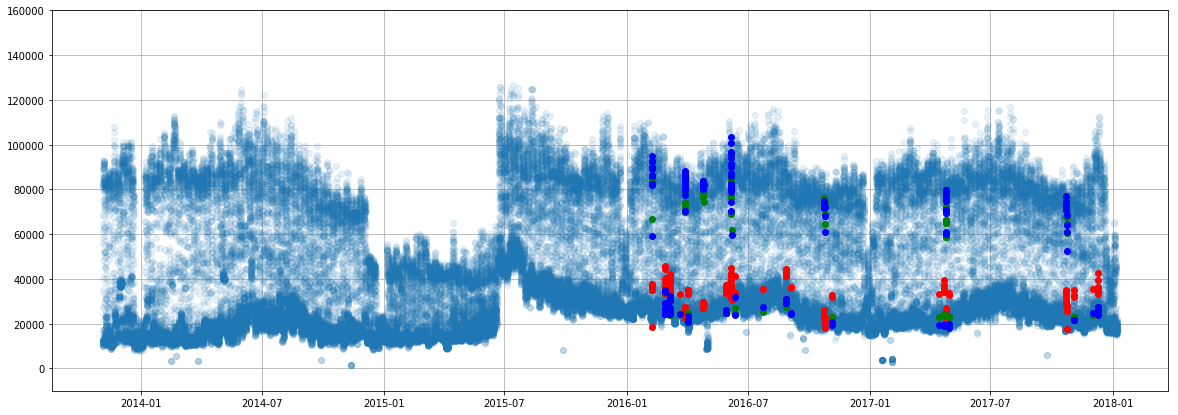

In [62]:
plt.figure(figsize=(20,7))
plt.plot(train.Timestamp,train.Values, 'o',alpha = 0.1)

plt.plot(train[train['is_abnormal'] == True].Timestamp,train[train['is_abnormal'] == True].Values, 'ro')
plt.plot(train[train['is_abnormal'] == True].Timestamp,train[train['is_abnormal'] == True].Values_pred_2, 'go')
plt.plot(train[train['is_abnormal'] == True].Timestamp,train[train['is_abnormal'] == True].Values_pred_1, 'bo')
plt.ylim(-10000,160000)
plt.grid(True)

In [63]:
train.is_abnormal.fillna(False,inplace = True)

In [64]:
with open(interim_path+'train_nn_knn_234_203.pkl', 'wb') as f:
    pickle.dump(train,f)

In [65]:
### You can check if you have the same number of labeled anomalies. For best submission I had 220 of anomalies here. 

train.is_abnormal.sum()

228